In [156]:
from glob import glob
from copy import deepcopy

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

from astropy.time import Time
from astropy.constants import R_sun, R_jup, M_sun, G
import astropy.units as u
from astropy.table import Table

from celerite import GP, terms, modeling
from batman import TransitParams, TransitModel
from fleck import Star

In [162]:
lc_paths = glob('data/aumic_b_visit*.csv')

In [163]:
class LightCurve(object): 
    def __init__(self, t, f, e): 
        self.time = t
        self.flux = f
        self.err = e
        
    @classmethod
    def from_csv(cls, lc_path):
        table = Table.read(lc_path, format='csv', 
                           header_start=4, data_start=5)
        t = Time(table['BMJD (BJD - 2400000.5d0)'].data + 
                 2400000.5, format='jd')
        f = table['Corrected Flux (Jy)'].data
        e = table['Corrected Uncertainty (Jy)'].data
        return cls(t[~np.isnan(f)], 
                   f[~np.isnan(f)] / np.median(f[~np.isnan(f)]), 
                   e[~np.isnan(f)] / np.median(f[~np.isnan(f)]))

In [222]:
p = TransitParams()

R_star = 0.84 * R_sun  # wikipedia
M_star = 0.31 * M_sun  # wikipedia

init_depth = 0.051  # Tom 
init_inc = 87.2  # manual retrieval
init_t0 = 1330.39153241 + 2457000 # Tom 
# init_lon = -35
init_contrast = 5

inc_stellar = 90 * u.deg
time_ref = 2458525.118161289

p.per = 8.46321 # Tom 
p.t0 = 1330.39153241 + 2457000 # Tom 

p.rp = 0.051 # Tom 
p.inc = 87.2
p.u = [0, 0]
p.limb_dark = 'quadratic'
p.w = 90
p.a = float(((G * M_star) / (4 * np.pi**2) * 
             (p.per * u.day)**2)**(1/3) / R_star)
p.ecc = 0
p.lam = 0

In [243]:
np.degrees(np.arcsin(p.a * np.cos(np.radians(p.inc))))

43.46073212958706

In [266]:
transit_model_kwargs = dict(supersample_factor=3, 
                            exp_time=1/60/24)

class MeanModel(modeling.Model):
    parameter_names = ("depth", "t0", "inc")

    def get_value(self, t):
        trial_p = deepcopy(p)
        trial_p.rp = self.depth**0.5
        trial_p.t0 = self.t0
        trial_p.inc = self.inc
        return TransitModel(trial_p, t, 
                            **transit_model_kwargs
                            ).light_curve(trial_p)

class MeanModelSpots(modeling.Model):
    parameter_names = ("t0", "inc", "lon", "contrast", "rad") # "depth", 

    def get_value(self, t):
        trial_p = deepcopy(p)
#         trial_p.rp = self.depth**0.5
        trial_p.t0 = self.t0
        trial_p.inc = self.inc
        lon = [[self.lon]] * u.deg
        lat = [[-45]] * u.deg
        rad = np.array([[self.rad]])
        star = Star(spot_contrast=self.contrast, u_ld=[0, 0], 
                    rotation_period=4.865)
        return star.light_curve(lon, lat, rad, inc_stellar, 
                                fast=True, planet=trial_p, 
                                times=t, time_ref=time_ref)[:, 0]

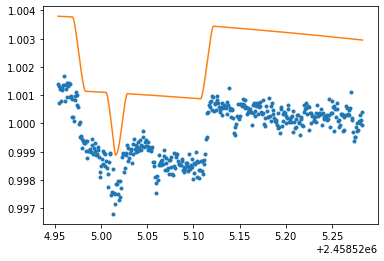

soln [ 2.45833039e+06  8.72023997e+01 -3.00002266e+01  1.99644533e+00
  6.37011158e-02]


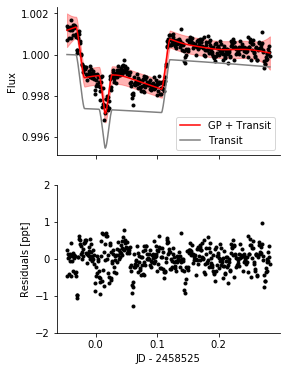

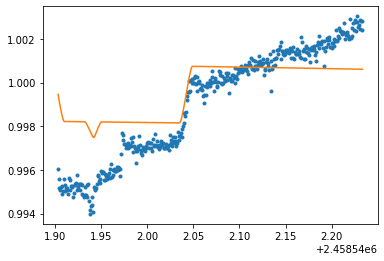

soln [2.45833039e+06 8.72364117e+01 1.39992300e+02 1.50587608e+00
 6.73565037e-02]


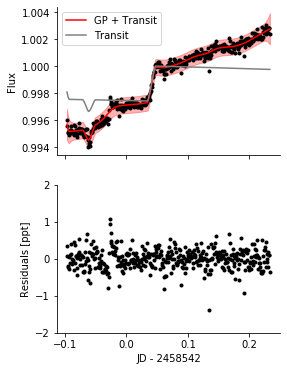

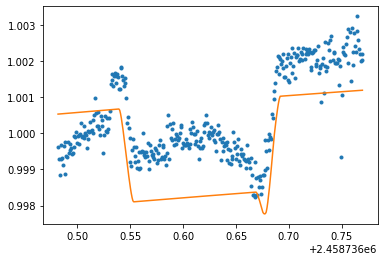

soln [ 2.45833038e+06  8.71180396e+01 -1.25005051e+02  1.37231504e+00
  5.10750316e-04]


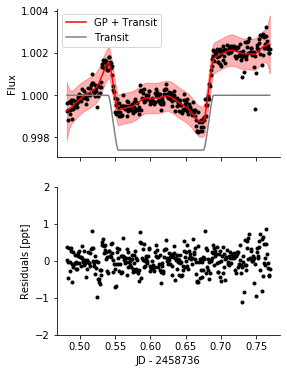

In [268]:
lcs = []

log_rhos = [2.5, 1.5, 1]
t0_offsets = [0, 0.001, -0.01]
locs = ['lower right', 'upper left', 'upper left']
contrasts = [2, 1.5, 1.5]
init_lons = np.array([-30, 140, -125])
init_rads = [0.075, 0.05, 0.075]

for i, lc_path in enumerate(lc_paths): 
    lc = LightCurve.from_csv(lc_path)
    lcs.append(lc)

    bounds = dict(t0=[init_t0 - 0.05 + t0_offsets[i], 
                      init_t0 + 0.05 + t0_offsets[i]],
                  inc=[87, 88.9], 
                  contrast=[1, 10],
                  lon=[-180, 180], 
                  rad=[0, 0.2])
                  #depth=[0.9 * init_depth, 1.1 * init_depth], 
                  
    gp = GP(terms.Matern32Term(log_sigma=1, log_rho=log_rhos[i]),
#             mean=MeanModel(depth=init_depth, t0=init_t0 + t0_offsets[i], inc=init_inc,
#                            bounds=bounds), 
            mean=MeanModelSpots(t0=init_t0 + t0_offsets[i], 
                                inc=init_inc, lon=init_lons[i], 
                                contrast=contrasts[i], 
                                rad=init_rads[i],
                                bounds=bounds), 
                                #depth=init_depth, 
            fit_mean=True)
    gp.kernel.freeze_parameter('log_sigma')
    gp.kernel.freeze_parameter('log_rho')
    
    gp.compute(lc.time.jd, lc.err)
    
    # Plot initial model
    plt.plot(lc.time.jd, lc.flux, '.')
    plt.plot(lc.time.jd, gp.mean.get_value(lc.time.jd))
    plt.show()
    
    
    # Define a cost function
    def neg_log_like(params, y, gp):
        gp.set_parameter_vector(params)
        return -gp.log_likelihood(y)

    # Fit for the maximum likelihood parameters
    initial_params = gp.get_parameter_vector()
    bounds = gp.get_parameter_bounds()
    soln = minimize(neg_log_like, initial_params,
                    method="L-BFGS-B", bounds=bounds, 
                    args=(lc.flux, gp))
    
    gp.set_parameter_vector(soln.x)
    print('soln', soln.x)
    soln_transit_params = soln.x[2:]
    soln_transit = gp.mean.get_value(lc.time.jd)
    
    model, var = gp.predict(lc.flux, return_var=True)
    std = np.sqrt(var)
    
    fig, ax = plt.subplots(2, 1, figsize=(4, 6), sharex=True)
    
    bjd_offset = int(lc.time.jd.mean())
    ax[0].plot(lc.time.jd - bjd_offset, lc.flux, '.', color='k')
    
    ax[0].plot(lc.time.jd - bjd_offset, model, 
               color='r', label='GP + Transit')
    ax[0].fill_between(lc.time.jd - bjd_offset, 
                       model - std, model + std, 
                       color='r', alpha=0.3, zorder=-10)

    ax[0].plot(lc.time.jd - bjd_offset, soln_transit / soln_transit.max(), 
               color='gray', label='Transit')
    
    ax[1].plot(lc.time.jd - bjd_offset, 1e3 * (lc.flux - model), 'k.')
    
    ax[1].set(xlabel=f"JD - {bjd_offset:d}", ylabel='Residuals [ppt]')
    ax[0].legend(loc=locs[i])
    ax[0].set_ylabel('Flux')
    
    for axis in ax: 
        for sp in ['right', 'top']: 
            axis.spines[sp].set_visible(False)
    ax[1].set_ylim([-2, 2])
    
    fig.savefig(f'plots/lc_{i}.pdf', bbox_inches='tight')
    plt.show()